In [41]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from glob import glob
from skimage.transform import resize

In [42]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

/bin/bash: /home/notomo/miniconda3/envs/myenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)
File ‘backgrounds.zip’ already there; not retrieving.



In [43]:
!unzip -n backgrounds.zip

/bin/bash: /home/notomo/miniconda3/envs/myenv/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Archive:  backgrounds.zip
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: __MACOSX/backgrounds/._7.jpg  
  inflating: __MACOSX/backgrounds/._6.jpg  
  inflating: __MACOSX/backgrounds/._2.jpg  
  inflating: __MACOSX/backgrounds/._3.jpg  
  inflating: __MACOSX/backgrounds/._1.jpg  


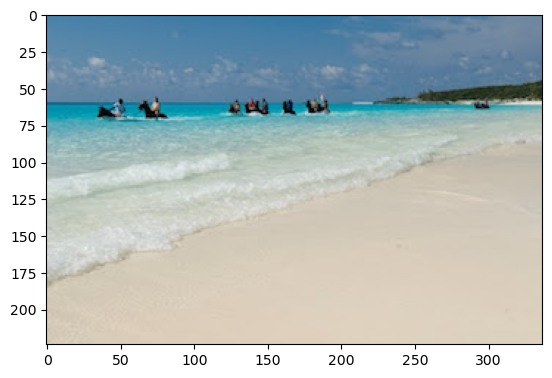

In [44]:
backgrounds = []
backgrounds_file = glob('backgrounds/*.jpg')

for file in backgrounds_file:
    img = np.array(image.load_img(file))
    backgrounds.append(img)

plt.imshow(backgrounds[2])

Height of the object image: 56
Width of the object image:  44
Number of color channels: 4


/tmp/ipykernel_6159/478119487.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch = imread(path)


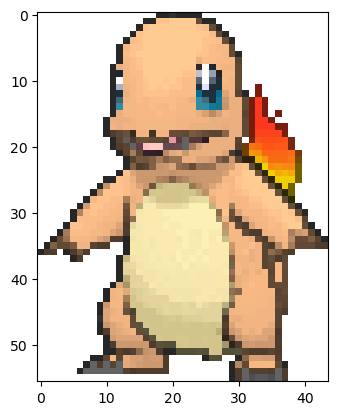

In [45]:
path = '/home/notomo/Documents/VSC/Models/ObjectLocalization/charmander-tight.png'
# path = '/content/charmander-tight.png'
ch = imread(path)

POKE_DIM = 200
ch = np.array(ch)
plt.imshow(ch)
CH_H, CH_W, CH_C = ch.shape

print(f'Height of the object image: {CH_H}')
print(f'Width of the object image:  {CH_W}')
print(f'Number of color channels: {CH_C}')

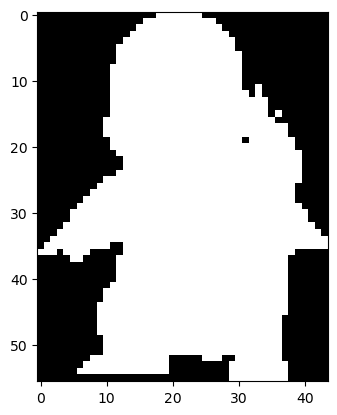

In [46]:
plt.imshow(ch[:, :, 3], cmap='gray')

In [47]:
def make_model():
    vgg = VGG16(input_shape= [POKE_DIM, POKE_DIM, 3],
                include_top=False,
                weights='imagenet')

    x = Flatten()(vgg.output)
    x = Dense(units=4, activation='sigmoid')(x) # 4 neurons corresponding to: x_topleft, y_topleft, height, width
    model = Model(vgg.input, x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))

    return model

In [48]:
def pokemon_generator_with_background(batch_size=64):
    while True:
        for _ in range(50): # number of batches in each epoch is just random (I chose 50)
            # Generate X - (batch_size, H, W, 3)
            # Generate y  - (batch_size, 4)
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            y = np.zeros(shape=(batch_size, 4)) # x_top_right, y_top_right, height, width

            for i in range(batch_size):
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape
                
                # Cut a random part on background image (200x200)
                cut_x = np.random.randint(0, bg_w - POKE_DIM)
                cut_y = np.random.randint(0, bg_h - POKE_DIM)
                X[i] = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

                
                # Resize Object (random)
                scale = np.random.random() + 0.5
                new_height, new_width = int(CH_H * scale), int(CH_W * scale)
                obj = resize(ch, (new_height, new_width),
                            preserve_range=True).astype(np.uint8)

                # Flip Object
                if np.random.random() < 0.5:
                    obj = np.fliplr(obj)
                
                # Locate the object on background image (at a random location)
                x0 = np.random.randint(0, POKE_DIM - new_width)
                y0 = np.random.randint(0, POKE_DIM - new_height)
                x1 = x0 + new_width
                y1 = y0 + new_height

                # Paste Object on background image
                mask = (obj[:, :, 3] == 0) # find where the object is 0
                bg_obj = X[i, y0:y0+new_height, x0:x0+new_width, :] # where we want to place `obj`
                bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
                bg_obj += obj[:, :, :3]
                X[i, y0:y0+new_height, x0:x0+new_width, :] = bg_obj

                y[i, 0] = x0 / POKE_DIM
                y[i, 1] = y0 / POKE_DIM
                y[i, 2] = (y1-y0) / POKE_DIM
                y[i, 3] = (x1-x0) / POKE_DIM

            yield X / 255., y

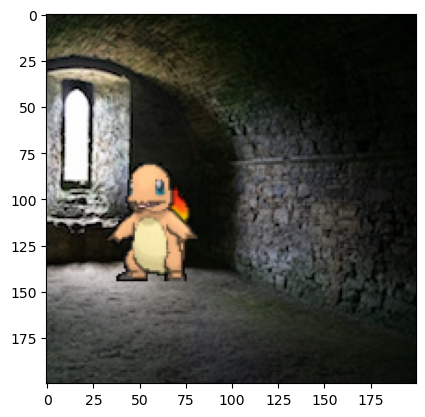

In [49]:
# Testing the function
xx = None
yy = None
for x, y in pokemon_generator_with_background():
    xx = x
    yy = x
    break
plt.imshow(xx[5])

In [ ]:
model = make_model()
model.fit_generator(
    pokemon_generator_with_background(),
    steps_per_epoch=50,
    epochs=5
)

In [ ]:
from matplotlib.patches import Rectangle

# Function to make prediction, everytime want to test the model, just run this function
def pokemon_predict_with_background():
    X = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    y = np.zeros(shape=(4)) # x_top_right, y_top_right, height, width

    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape
    
    # Cut a random part on background image (200x200)
    cut_x = np.random.randint(0, bg_w - POKE_DIM)
    cut_y = np.random.randint(0, bg_h - POKE_DIM)
    X = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

    
    # Resize Object (random)
    scale = np.random.random() + 0.5
    new_height, new_width = int(CH_H * scale), int(CH_W * scale)
    obj = resize(ch, (new_height, new_width),
                preserve_range=True).astype(np.uint8)

    # Flip Object
    if np.random.random() < 0.5:
        obj = np.fliplr(obj)
    
    # Locate the object on background image (at a random location)
    x0 = np.random.randint(0, POKE_DIM - new_width)
    y0 = np.random.randint(0, POKE_DIM - new_height)
    x1 = x0 + new_width
    y1 = y0 + new_height

    # Paste Object on background image
    mask = (obj[:, :, 3] == 0) # find where the object is 0
    bg_obj = X[y0:y0+new_height, x0:x0+new_width, :] # where we want to place `obj`
    bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
    bg_obj += obj[:, :, :3]
    X[y0:y0+new_height, x0:x0+new_width, :] = bg_obj

    y[0] = x0 / POKE_DIM
    y[1] = y0 / POKE_DIM
    y[2] = (y1-y0) / POKE_DIM
    y[3] = (x1-x0) / POKE_DIM

    X = np.expand_dims(X, axis=0) / 255.
    y = np.expand_dims(y, axis=0)
    prediction = model.predict(X)[0]
    prediction = prediction * POKE_DIM

    row0 = int(prediction[0])
    col0 = int(prediction[1])
    row1 = int(row0 + prediction[2])
    col1 = int(col0 + prediction[3])
    print("pred:", row0, col0, row1, col1)
    print("loss:", -np.mean(y * np.log(prediction / POKE_DIM) + (1 - y)*np.log(1-prediction / POKE_DIM)))

    rect = Rectangle((prediction[0], prediction[1]),
                     height=prediction[2], width=prediction[3],
                     edgecolor='r',
                     linewidth=3,
                     facecolor='none')
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X[0])
    ax.add_patch(rect)

    plt.show()


# Run function
pokemon_predict_with_background()